In [2]:
import sys
import os
sys.path.append('../../') # Add the root directory to sys.path

In [3]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from models.testmodel import TestConvModel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

In [4]:
data_dir = '../../data/Gaia DR3/train.parquet'

In [5]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,G,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,B,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,F,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,B,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,B,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [6]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,2264606414026248192,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14101 entries, 0 to 14100
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  14101 non-null  int64 
 1   Cat        14101 non-null  object
 2   flux       14101 non-null  object
dtypes: int64(1), object(2)
memory usage: 330.6+ KB


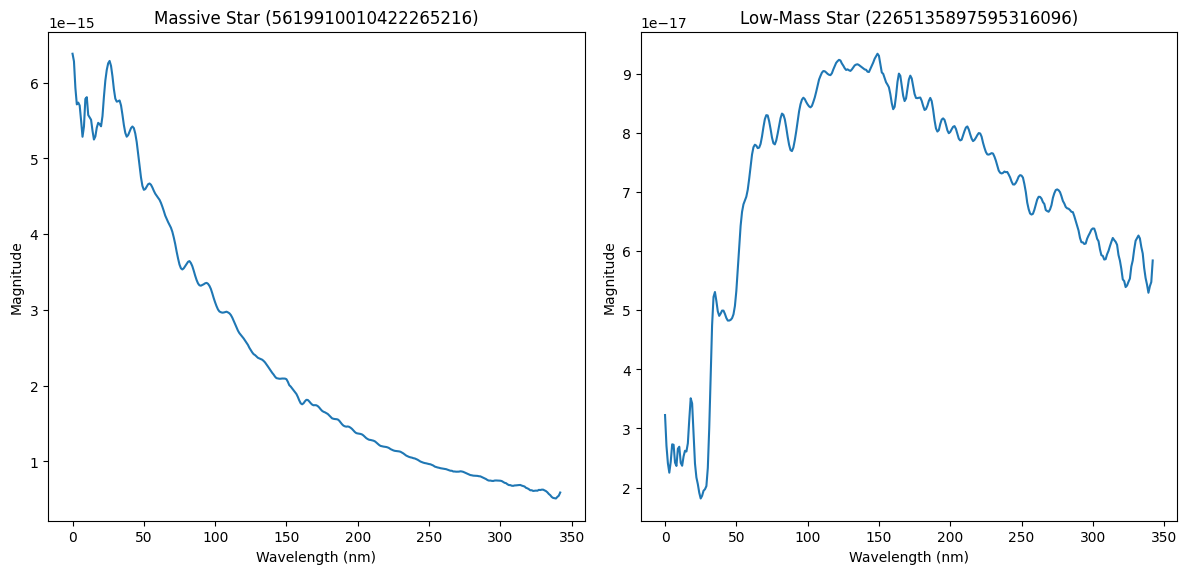

In [8]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [9]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 14101
Number of bins in each spectra: 343
In the dataset, we have 8820 spectra for low mass stars and 5281 spectra for high mass stars.


In [10]:
X = df['flux'].to_numpy()
y = df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([x / np.linalg.norm(x, keepdims=True) for x in X])).float()

In [11]:
def extend_curves(curves):
    '''
    function to extended loss curves to the same length
    '''
    max_length = max(len(curve) for curve in curves)
    
    extended_curves = []
    for curve in curves:
        last_value = curve[-1]
        extended_curve = curve + [last_value] * (max_length - len(curve))
        extended_curves.append(extended_curve)
    
    return np.array(extended_curves)

def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def fit_model(model, x_train, y_train, x_val, y_val, prt_steps = 1, verbose=True):
    
    model.apply(init_weights)

    # hyperparameters
    epochs = 50
    learning_rate = 1e-4
    batch_size = 32
    device = 'cuda'

    # early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train.numpy())).to(device)

    # model components
    criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.unsqueeze(1).to(device)
    x_val = x_val.to(device)
    y_val = y_val.unsqueeze(1).to(device)

    # metrics
    training_losses, validation_losses = [], []
    accuracy = []
    
    # lr cycling
    max_lr = 1e-3
    steps_per_epoch = (len(x_train) + batch_size - 1) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    t = tqdm(range(epochs), dynamic_ncols=True)

    for epoch in t:
        t.set_description(f'Epoch {epoch+1}')
        
        model.train()
        running_loss = 0

        for start in batch_start:

            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            output = model(x_batch.unsqueeze(1))
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        model.eval()
        preds, labels = [], []

        with torch.no_grad():
            
            output = model(x_val.unsqueeze(1))
            loss = criterion(output, y_val)

            probs = torch.sigmoid(output)
            pred = torch.round(probs).cpu().numpy().astype(float)  # pred: [batch_size]
            
            preds.extend(pred)
            labels.extend(y_val.cpu().numpy())
            
            val_loss = loss.item()
        
        epoch_acc = accuracy_score(labels, preds)
        validation_losses.append(val_loss)
        accuracy.append(epoch_acc)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {epoch_acc:.4f}', end='\r')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    return training_losses, validation_losses, accuracy

In [12]:
kfold = StratifiedKFold(n_splits=5)

training_losses_foldx, validation_losses_foldx, accuracy_scores_foldx = [], [], []

model = TestConvModel()
print(model)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    tr_loss, val_loss, acc = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], prt_steps=1, verbose=True)
    training_losses_foldx.append(tr_loss)
    validation_losses_foldx.append(val_loss)
    accuracy_scores_foldx.append(acc)

training_losses = np.mean(extend_curves(training_losses_foldx), axis=0)
validation_losses = np.mean(extend_curves(validation_losses_foldx), axis=0)
accuracy_scores = np.mean(extend_curves(accuracy_scores_foldx), axis=0)

TestConvModel(
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1360, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

Fitting fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 43, Accuracy: 0.9670

Fitting fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 41, Accuracy: 0.9741

Fitting fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 42, Accuracy: 0.9738

Fitting fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 38, Accuracy: 0.9688

Fitting fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

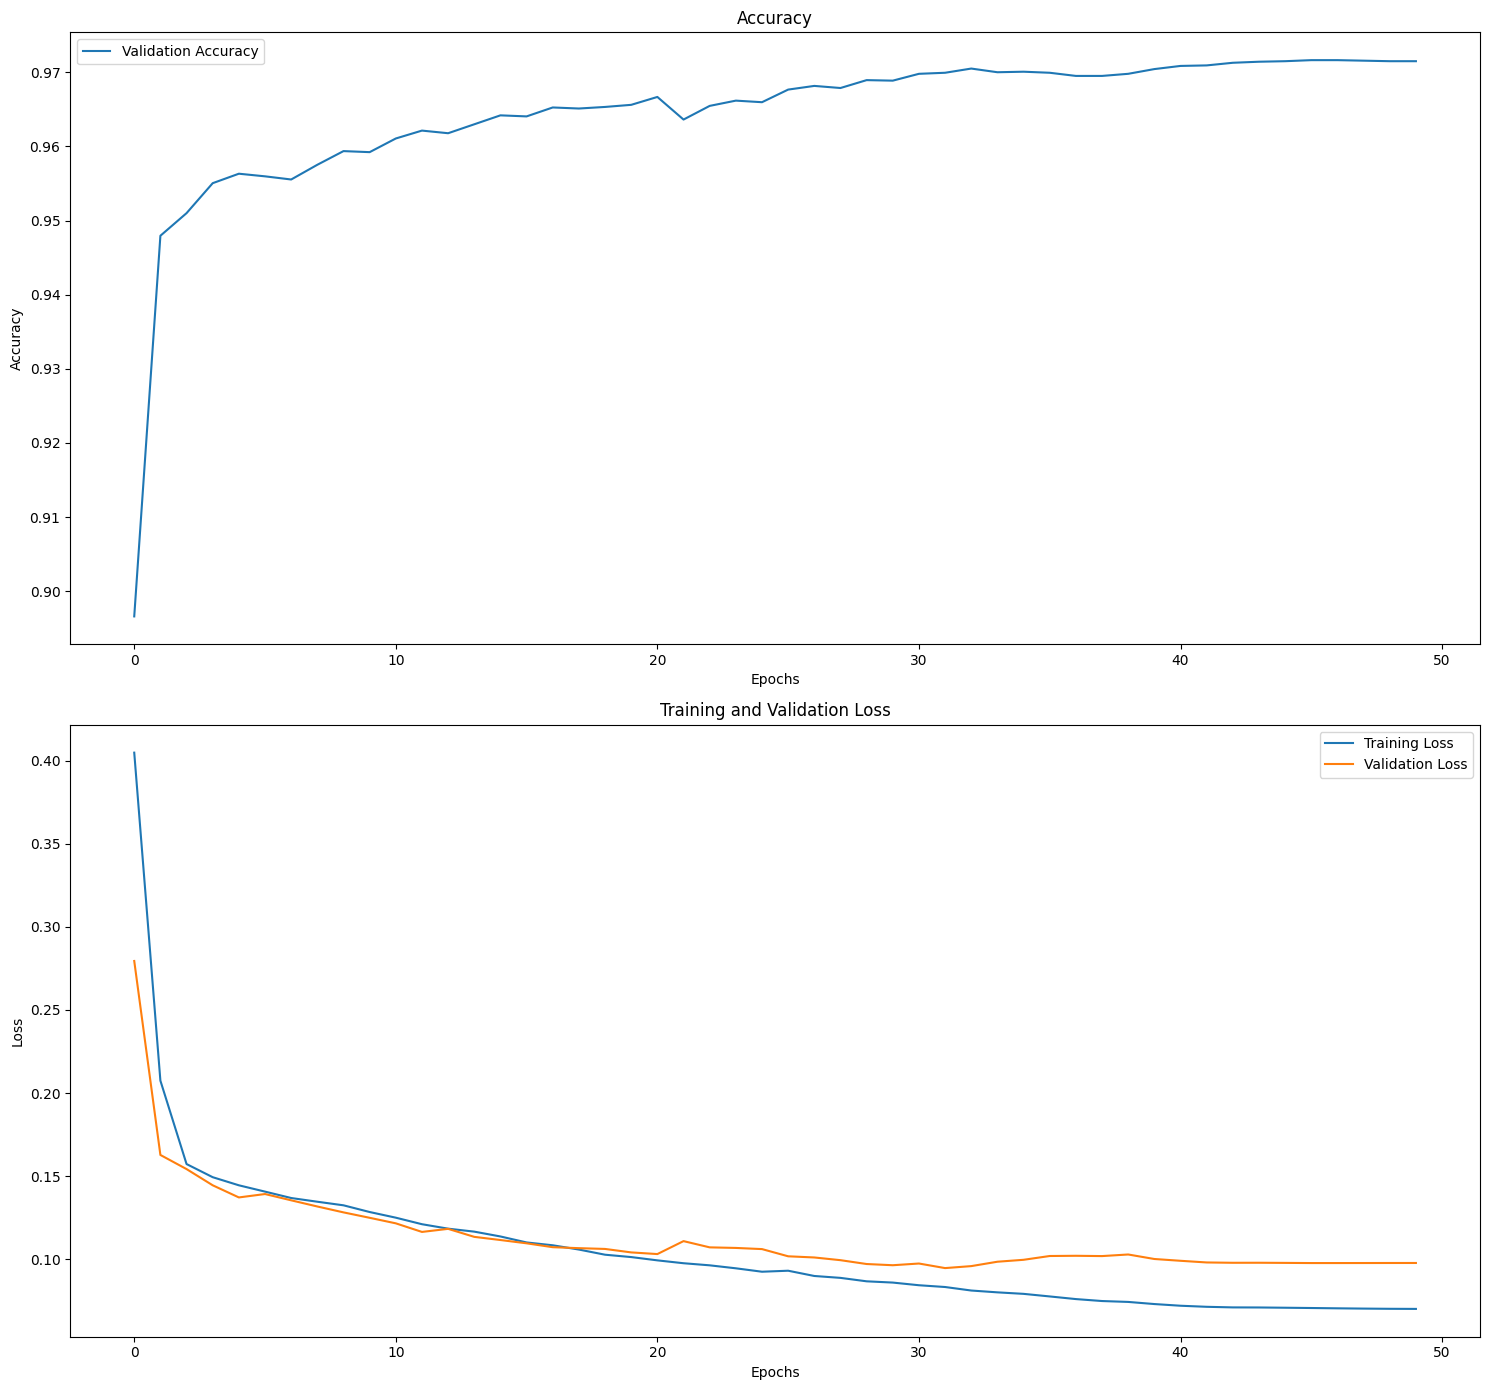

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))
    
ax1.plot(accuracy_scores, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(training_losses, label='Training Loss')
ax2.plot(validation_losses, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()